In [3]:
import json 
import urllib
import re

import urllib2
import csv
import time

import numpy as np
import codecs
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import scipy as sc
from nltk.tokenize import wordpunct_tokenize
from nltk import PorterStemmer
import lda
import xlrd

path="/media/jupiter/hadoopuser/amazon/data/"


#load stopwords
from nltk.corpus import stopwords  

#pull reviews
fd = open(path+"drill_reviews_20150611.json", "r")
drill_reviews = json.load(fd)
fd.close()
#pull product info
fd = open(path + "meta_drill_final.json", "r")
meta_drill = json.load(fd)
product_info=pd.DataFrame(meta_drill)

for item in meta_drill:
    if item['price'] != 'unavailable':
        item['price_int'] = float(re.sub('\$','', item['price']))
        if float(re.sub('\$','', item['price'])) > 100:
            item['priceGroup']="$100-$200"
        else:
            item['priceGroup']="$50-$100"


##removing duplicate reviews for 2 different product ids        
from operator import itemgetter
newlist = sorted(drill_reviews, key=itemgetter('reviewId','asin'))

#remove duplicates
last_id= newlist[0]["reviewId"]
drill_reviews=[newlist[0]]
for item in newlist[1:]:
    if item["reviewId"] != last_id:
        drill_reviews.append(item)    
        last_id=item["reviewId"]
len(drill_reviews)

####DATA CLEANING

for items in drill_reviews:
    items["reviewText_new"]=items["reviewText"].replace('\\', ' ').replace('`', ' ').replace('*', ' ').replace('_', ' ').replace('{', ' ').replace('}', ' ').replace('[', ' ').replace(']', ' ').replace('(',' ').replace(')', ' ').replace('>', ' ').replace('#', ' ').replace('+', ' ').replace('-', ' ').replace('"', ' ').replace('!', ' ').replace('$', ' ').replace('&', ' ').replace('/',' ').replace("'",' ').replace(':',' ').replace('=',' ').replace(';',' ').replace('.',' ').replace(',',' ').replace('?',' ').replace("^"," ").replace("%"," ")
    items["reviewText_new"]=re.sub('\d+','',items["reviewText_new"])
    items["reviewText_new"]=re.sub('[^A-Za-z]',' ',items["reviewText_new"])
            
        

print(drill_reviews[5])
len(drill_reviews)

ImportError: No module named lda

In [2]:
import reviewsClasses as RC

special_stopwords= ['drill','tool','amazon']
keepList=['no', 'not','don','again','very', 'only'] 
#try stemming from NLTK porter stemmer
collection = RC.ReviewCollection(drill_reviews,'PS', keepList)


('docs removed:', '47')


In [3]:
#try lemmatizing function from NLTK
collectionL=RC.ReviewCollection(drill_reviews,'L')
print(collection.N)
print(collectionL.N)
x=collection.docs[1]
print(x.tokens)

('docs removed:', '48')
14257
14256
[u'happi']


In [4]:
len(collection.collection_tokens)
collection.N

14257

In [5]:
[item for item in collection.collection_tokens if item=='amazon']

[u'amazon']

##Exploratory Analysis

Populating the interactive namespace from numpy and matplotlib


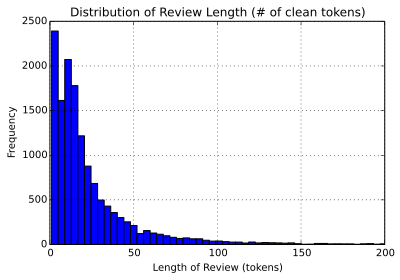

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as ply

length = pd.Series([len(rev.tokens) for rev in collection.docs])
h1 = length.hist(bins=200)
h1.set_xlabel("Length of Review (tokens)")
h1.set_ylabel("Frequency")
h1.set_title("Distribution of Review Length (# of clean tokens)")
pylab.xlim([0,200])
ply.savefig("images/ex_rev_len.png", dpi = 500, bbox_inches='tight')



In [7]:
#% of reviews less than 50 words long
(len([len(rev.tokens) for rev in collection.docs if len(rev.tokens) <30]) * 1.0)/collection.N

0.7547871221154521

Populating the interactive namespace from numpy and matplotlib


(0, 200)

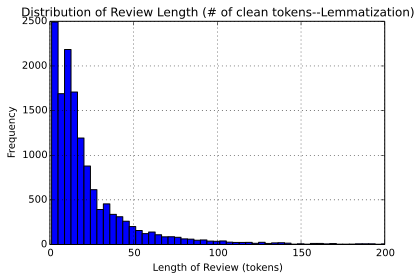

In [8]:
#NLTK's lemmatizing function using wordnet doesn't seem to help

%pylab inline
length = pd.Series([len(rev.tokens) for rev in collectionL.docs])
h1 = length.hist(bins=200)
h1.set_xlabel("Length of Review (tokens)")
h1.set_ylabel("Frequency")
h1.set_title("Distribution of Review Length (# of clean tokens--Lemmatization)")
pylab.xlim([0,200])

         reviewId  tokenLength  reviewStars
0  R100MLLP5JEO2A            6            5
1  R100XFA124F3M2            1            5
2  R100Y9O8UJJQL8            1            5
3  R1017GW3DM5AJO            8            5
4  R101GIAXB9HSTI           50            3

[5 rows x 3 columns]


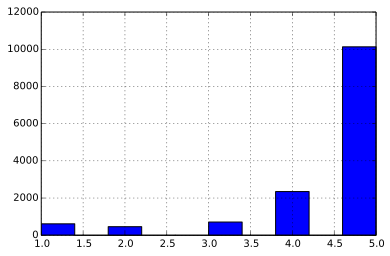

In [9]:
review_words=pd.DataFrame([[doc.reviewId, len(doc.tokens), doc.reviewStars] for doc in collection.docs])
review_words.columns = ["reviewId", "tokenLength", "reviewStars"]
print(review_words.head())
h2=review_words.loc[:,'reviewStars'].hist()

ply.savefig("images/rev_star.png", dpi = 400, bbox_inches='tight')

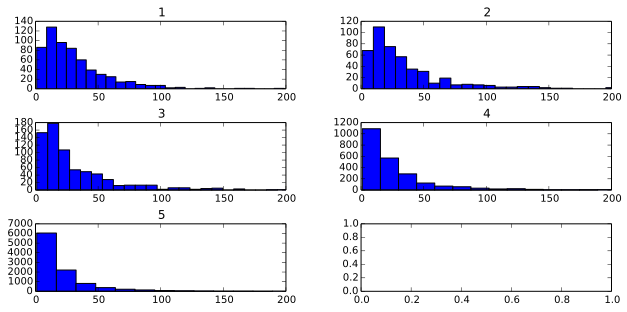

In [10]:
import matplotlib.pylab as ply
h3 = review_words["tokenLength"].hist(by = review_words["reviewStars"])
h3[0][0].set_xlim((0,200))
h3[0][1].set_xlim((0,200))
h3[1][0].set_xlim((0,200))
h3[1][1].set_xlim((0,200))
h3[2][0].set_xlim((0,200))
ply.savefig("images/ex_by_star.png", dpi = 400, bbox_inches='tight')

#Answering the Question
##Topic Analysis

In [11]:
dtm = collection.get_doc_term_mat()
dtm.shape

(14257, 9079)

In [12]:
#getting token counts
#sum columns to get tokens
token_count = dtm.sum(0)
size = token_count.sum(0)
token_count.sort(ascending=False)
token_count_top_20 = token_count[0:20] / size
token_count_top_20

batteri    0.026895
use        0.022408
great      0.013688
power      0.013098
not        0.012988
work       0.012629
one        0.012409
veri       0.011436
good       0.010429
charg      0.009642
light      0.008380
bit        0.007738
like       0.007543
need       0.007302
time       0.007200
drill      0.007184
price      0.006767
would      0.006698
dewalt     0.006624
well       0.006575
dtype: float64

In [13]:
model, vocab = collection.lda(dtm,10,1000)
topic_word = model.topic_word_

In [14]:
n_top_words = 10
#Get words with max probability for each topic
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i + 1, ' '.join(topic_words).encode('utf-8')))

Topic 1: use hous around job need not project power work
Topic 2: batteri tool volt dewalt driver black decker saw charger
Topic 3: love great husband use bought gift one christma veri
Topic 4: light power veri batteri use weight well size good
Topic 5: great good product veri price work excel recommend would
Topic 6: bit screw use drill chuck hole not drive driver
Topic 7: case bit batteri come one nice charger like carri
Topic 8: batteri charg use time long last power hold work
Topic 9: not use batteri one would work review product dewalt
Topic 10: one batteri dewalt year use old replac last buy


In [15]:
model, vocab = collection.lda(dtm,5,1000)
topic_word = model.topic_word_

In [16]:
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i + 1, ' '.join(topic_words).encode('utf-8')))

Topic 1: use great hous around work love need power job
Topic 2: batteri power use one volt tool dewalt charg driver
Topic 3: bit use screw chuck not drill light power batteri
Topic 4: batteri one not use dewalt work year charg buy
Topic 5: great veri good batteri power work product price use


In [17]:
print(product_info.columns)
product_info2=product_info.iloc[:,[0,4,6]].sort(['numOfReviews', 'price'], ascending=[0, 0])
product_info2.head()

Index([u'asin', u'category', u'dateFirstAvailable', u'description', u'numOfReviews', u'otherSellers', u'price', u'productTitle', u'productsAlsoViewed', u'productsPurchasedAfter', u'savings', u'scrapeDate', u'shipping'], dtype='object')


,asin,numOfReviews,price
43,B002RLR0EY,2407,$99.00
86,B005NNF0YU,1126,$54.88
76,B005G2S0A4,536,$39.99
41,B00BD9XO1O,512,$59.97
64,B004443WVW,512,$46.98


In [18]:
item_reviews=[doc for doc in drill_reviews if doc['asin'] =='B002RLR0EY']

keepList=['very'] 
item_collection = RC.ReviewCollection(item_reviews,'PS', keepList)

('docs removed:', '7')


In [19]:
item_dtm = item_collection.get_doc_term_mat()
token_count = item_dtm.sum(0)
size = token_count.sum(0)
token_count.sort(ascending=False)
token_count_top_10 = token_count[0:10] / size
token_count_top_10

batteri    0.034239
use        0.022950
great      0.021566
dewalt     0.019862
one        0.014501
work       0.014427
good       0.013982
power      0.013019
veri       0.012204
price      0.010820
dtype: float64

In [20]:
item_model, item_vocab = item_collection.lda(item_dtm,5,1000)
item_topic_word = item_model.topic_word_


In [21]:
n_top_words = 5
for i, topic_dist in enumerate(item_topic_word):
    topic_words = np.array(item_vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i + 1, ' '.join(topic_words).encode('utf-8')))

Topic 1: great product love good price
Topic 2: dewalt use one chuck work
Topic 3: batteri use power charg time
Topic 4: case work great batteri good
Topic 5: batteri dewalt one year use


In [22]:
item_review_words=pd.DataFrame([[doc.reviewId, len(doc.tokens), doc.reviewStars] for doc in item_collection.docs])
